In [1]:
import os
import keras
import numpy as np
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Reshape, ZeroPadding2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

from keras import regularizers
from keras.layers.core import Lambda
# from generators import read_data,reshape

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 50000 images
Test Set Size = 10000 images


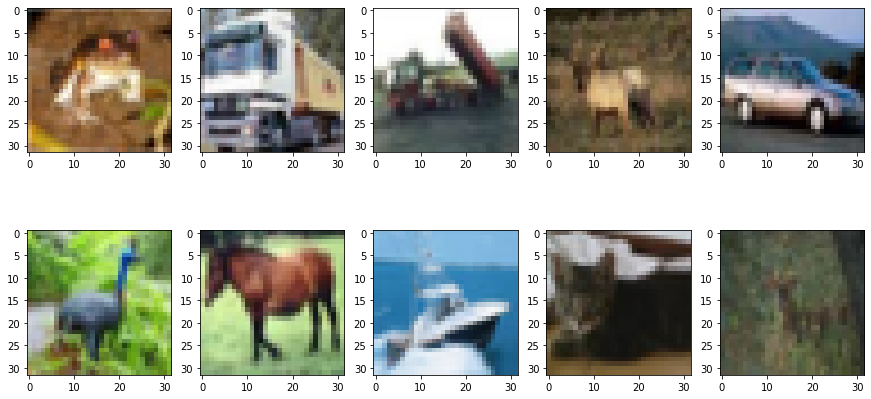

Labels : [[6]
 [9]
 [9]
 [4]
 [1]]
Labels : [[2]
 [7]
 [8]
 [3]
 [4]]


In [3]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [4]:
num_classes= None
img_rows, img_cols = 32, 32


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
# input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

x_train_dataset shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
# Copy data to 3 channels and resample to get 56x56 images
# VGG needs atleast 48x48, so resample
# Center and resample diffraction array to desired pixel spacing
from scipy.ndimage.interpolation import zoom

def resample(diff3D, Nx, Ny): 
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D


from tqdm import tqdm
def copy3channels(input_data):
    dims = input_data.shape
    # dataset3 = np.zeros((dims[0],28,28,3),float)
    # for i in tqdm(range(dims[0])):
    #    dataset3[i,:,:,0], dataset3[i,:,:,1], dataset3[i,:,:,2] = input_data[i,:,:,0], input_data[i,:,:,0], input_data[i,:,:,0]
    data=[]
    for i in tqdm(range(dims[0])):
        tmp=resample(input_data[i,:,:,:],64,64)
        data.append(tmp)
    return np.array(data)

In [6]:
x_train_prepro = copy3channels(x_train)
x_test_prepro = copy3channels(x_test)

100%|██████████| 10000/10000 [00:10<00:00, 988.07it/s]


In [7]:
x_train_prepro.shape

(50000, 64, 64, 3)

In [12]:
weight_decay = 0.0005
def vgg_16(input_shape):
    input_tensor=Input(shape=input_shape)
    # x = ZeroPadding2D(padding=(2, 2))(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
    kernel_regularizer=regularizers.l2(weight_decay), name='block1_conv1')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)


    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    model = Model(inputs=[input_tensor],outputs=[x])

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model


model = vgg_16((64,64,3))

In [13]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       7385

In [14]:
nb_epoch = 50
batch_size = 256

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.15, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [15]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# time
predictions, history = run_vgg16()
print(model.summary())

Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 95s 2ms/step - loss: 7.9476 - accuracy: 0.2738 - val_loss: 7.9461 - val_accuracy: 0.1437
Epoch 2/50
42500/42500 [==============================] - 87s 2ms/step - loss: 7.5859 - accuracy: 0.3284 - val_loss: 7.4328 - val_accuracy: 0.2971
Epoch 3/50
42500/42500 [==============================] - 87s 2ms/step - loss: 7.2478 - accuracy: 0.3912 - val_loss: 7.2367 - val_accuracy: 0.3739
Epoch 4/50
42500/42500 [==============================] - 87s 2ms/step - loss: 7.1219 - accuracy: 0.4131 - val_loss: 7.0323 - val_accuracy: 0.4165
Epoch 5/50
42500/42500 [==============================] - 87s 2ms/step - loss: 6.9273 - accuracy: 0.4628 - val_loss: 9.1716 - val_accuracy: 0.2281
Epoch 6/50
42500/42500 [==============================] - 87s 2ms/step - loss: 6.9336 - accuracy: 0.4590 - val_loss: 6.7524 - val_accuracy: 0.4840
Epoch 7/50
42500/42500 [==============================] - 87s 2ms/ste

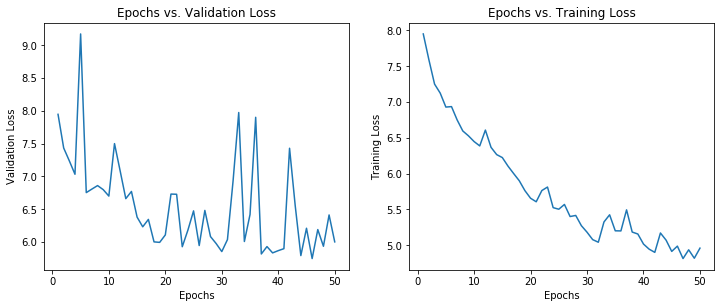

In [16]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,51), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,51), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

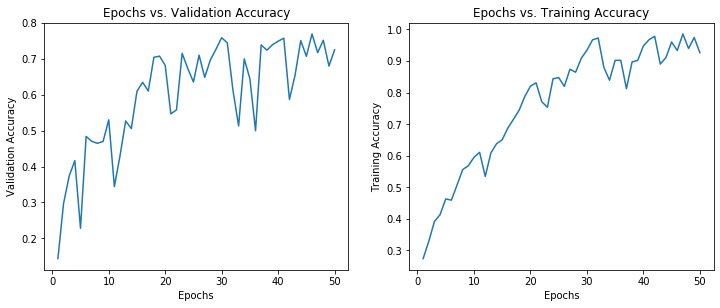

In [17]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,51), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,51), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [18]:
import h5py
model.save_weights('cifar_regu_weights.h5')
vggmodel_json = model.to_json()
with open ("cifar_regu.json", "w") as json_file:
    json_file.write(vggmodel_json)

In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from keras.models import model_from_json
json_file = open('cifar_regu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("cifar_regu_weights.h5")

sgd2=SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
loaded_model.compile(loss='categorical_crossentropy', optimizer = sgd2, metrics=['accuracy'] )

In [21]:
def run_vgg16_2():
    
    history = LossHistory()
    loaded_model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.15, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = loaded_model.predict(x_test_prepro, verbose=0)
    return predictions, history

In [22]:
nb_epoch=20
predictions1, history1 = run_vgg16_2()

Train on 42500 samples, validate on 7500 samples
Epoch 1/20
42500/42500 [==============================] - 93s 2ms/step - loss: 4.7738 - accuracy: 0.9830 - val_loss: 5.6319 - val_accuracy: 0.7857
Epoch 2/20
42500/42500 [==============================] - 88s 2ms/step - loss: 4.7539 - accuracy: 0.9897 - val_loss: 5.6331 - val_accuracy: 0.7893
Epoch 3/20
42500/42500 [==============================] - 88s 2ms/step - loss: 4.7478 - accuracy: 0.9918 - val_loss: 5.6413 - val_accuracy: 0.7889
Epoch 4/20
42500/42500 [==============================] - 88s 2ms/step - loss: 4.7492 - accuracy: 0.9906 - val_loss: 5.6436 - val_accuracy: 0.7875
Epoch 5/20
42500/42500 [==============================] - 88s 2ms/step - loss: 4.7362 - accuracy: 0.9948 - val_loss: 5.6400 - val_accuracy: 0.7863
Epoch 6/20
42500/42500 [==============================] - 88s 2ms/step - loss: 4.7360 - accuracy: 0.9946 - val_loss: 5.6442 - val_accuracy: 0.7879
Epoch 7/20
42500/42500 [==============================] - 87s 2ms/ste

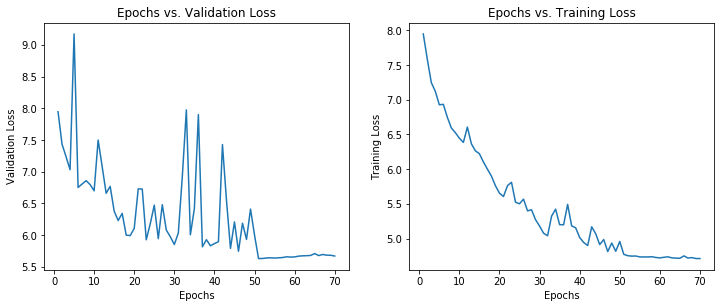

In [23]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,71), history.val_losses+history1.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,71), history.losses+history1.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

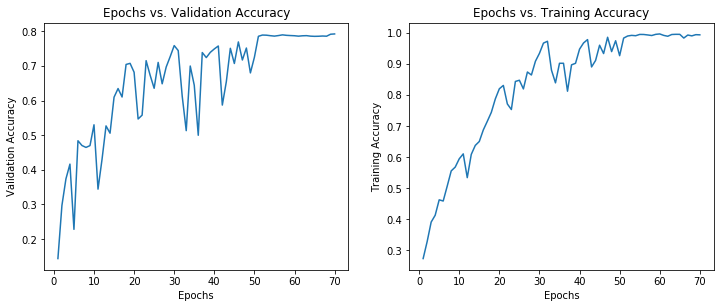

In [24]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,71), history.val_accuracy+history1.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,71), history.accuracy+history1.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

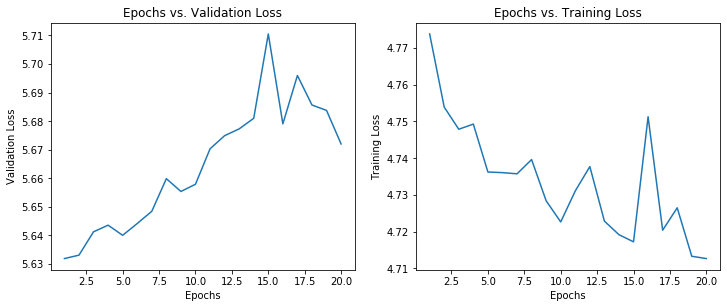

In [26]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,21), history1.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,21), history1.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

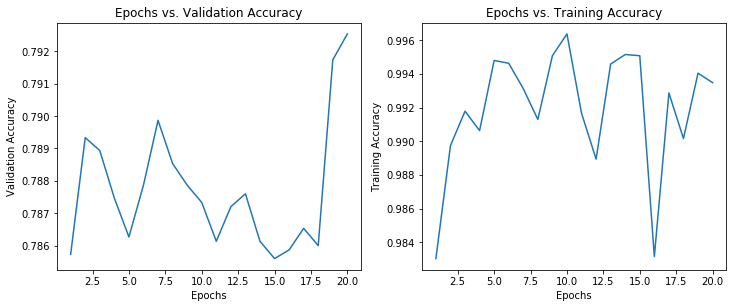

In [25]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,21), history1.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,21), history1.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()